In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS, BASIC_MASKS
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP

plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import torch
torch.cuda.set_device(1)

In [4]:

config = {
    'nn_runs': 200,
    'verbose': False,
    'use_cache': False, 
    'layers': [1, 128, 128, 64, 1],
    'patience': 10,
    'dropout_train': 0.2,
    'dropout_uq': 0.5
}

### Visualizing on toy data

#### Generate dataset


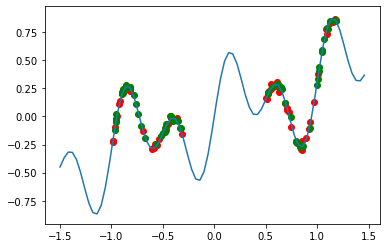

In [5]:
# dataset = 'qubic'
dataset = 'sin'
 
if dataset == 'qubic':
    x_train, y_train = ToyQubicData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToyQubicData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToyQubicData().dataset('ground_truth')
else:
    x_train, y_train = ToySinData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToySinData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToySinData().dataset('ground_truth')
    
plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')


#### Train model


Epoch [50/10000], Loss: 0.0468, Validation loss: 0.0271
Epoch [100/10000], Loss: 0.0052, Validation loss: 0.0107
Epoch [150/10000], Loss: 0.0486, Validation loss: 0.0132
Epoch [200/10000], Loss: 0.0049, Validation loss: 0.0085
Epoch [250/10000], Loss: 0.0040, Validation loss: 0.0057
Epoch [300/10000], Loss: 0.0152, Validation loss: 0.0046
Epoch [350/10000], Loss: 0.0078, Validation loss: 0.0042
Epoch [400/10000], Loss: 0.0172, Validation loss: 0.0032
Epoch [450/10000], Loss: 0.0015, Validation loss: 0.0054
Epoch [500/10000], Loss: 0.0072, Validation loss: 0.0055
Epoch [550/10000], Loss: 0.0150, Validation loss: 0.0049
Epoch [600/10000], Loss: 0.0041, Validation loss: 0.0055
Epoch [650/10000], Loss: 0.0064, Validation loss: 0.0073
Epoch [700/10000], Loss: 0.0033, Validation loss: 0.0066
Epoch [750/10000], Loss: 0.0036, Validation loss: 0.0062
Epoch [800/10000], Loss: 0.0017, Validation loss: 0.0057
Epoch [850/10000], Loss: 0.0047, Validation loss: 0.0074
Epoch [900/10000], Loss: 0.0008,

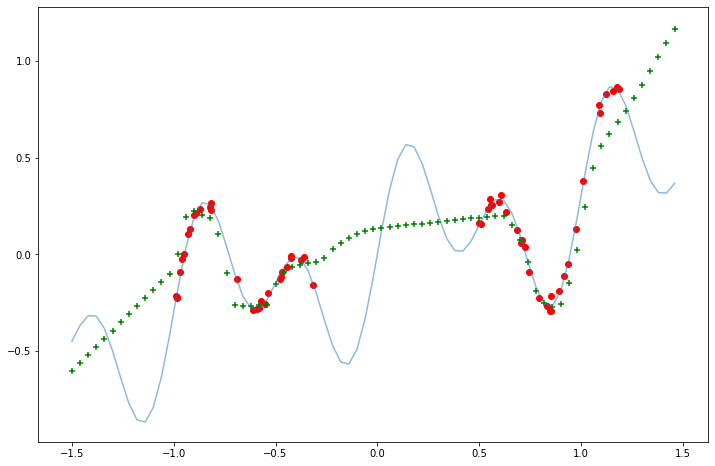

In [6]:
model = MLP(config['layers'], l2_reg=1e-5)
model.fit((x_train, y_train), (x_train, y_train), patience=config['patience'], validation_step=50, batch_size=5, dropout_rate=config['dropout_train'])

y_pred = model(x_true).cpu().numpy()
plt.figure(figsize=(12, 8))
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')



#### Evaluate UQ and plot the results


In [7]:
# masks = build_masks(DEFAULT_MASKS, nn_runs=config['nn_runs'])
masks = build_masks(nn_runs=config['nn_runs'])

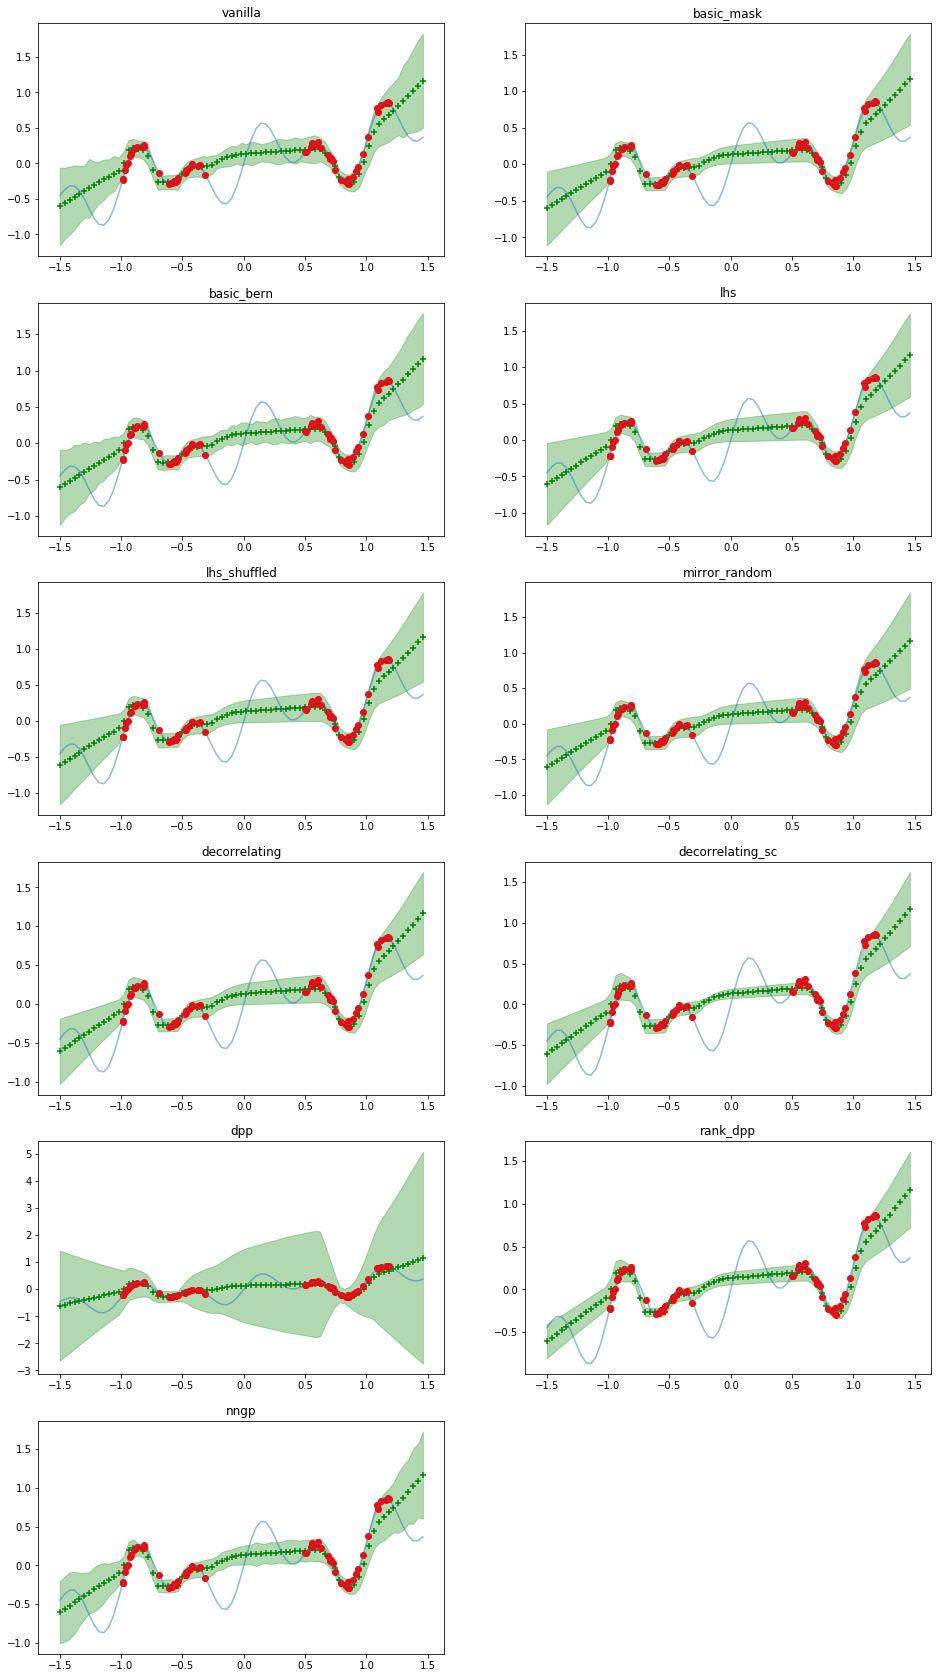

In [8]:
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')


dropout_runs = {}

for i, (name, mask) in enumerate(masks.items()):
    if hasattr(mask, 'reset'):
        mask.reset()
    estimator = build_estimator(
        'mcdue_masked', model, keep_runs=True, nn_runs=config['nn_runs'],
        dropout_mask=mask, dropout_rate=config['dropout_uq'])
    
    estimations = estimator.estimate(x_true)
    dropout_runs[name] = estimator.last_mcd_runs()
    plt.subplot(6, 2, i+1)
    make_uq_graph(name, estimations)

    
nngp = build_estimator('nngp', model, nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = nngp.estimate(x_true, x_train)
plt.subplot(6, 2, len(masks)+1)
make_uq_graph('nngp', estimations)


### Dropout predictions


In [9]:
def plot_dropout_runs(name, predictions, n=50):
    plt.figure(figsize=(20, 10))
    plt.title(name)
    plt.plot(x_true, y_true)
    plt.scatter(x_train, y_train, color='red')
    for prediction_line in predictions[:n]:
        plt.plot(x_true, prediction_line, alpha=0.5)

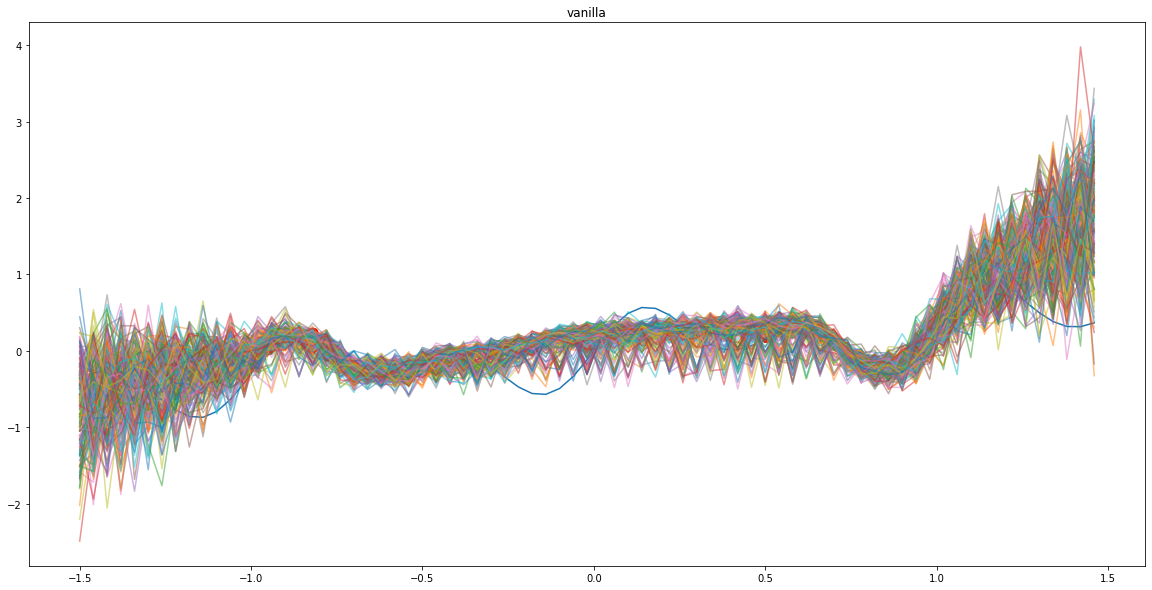

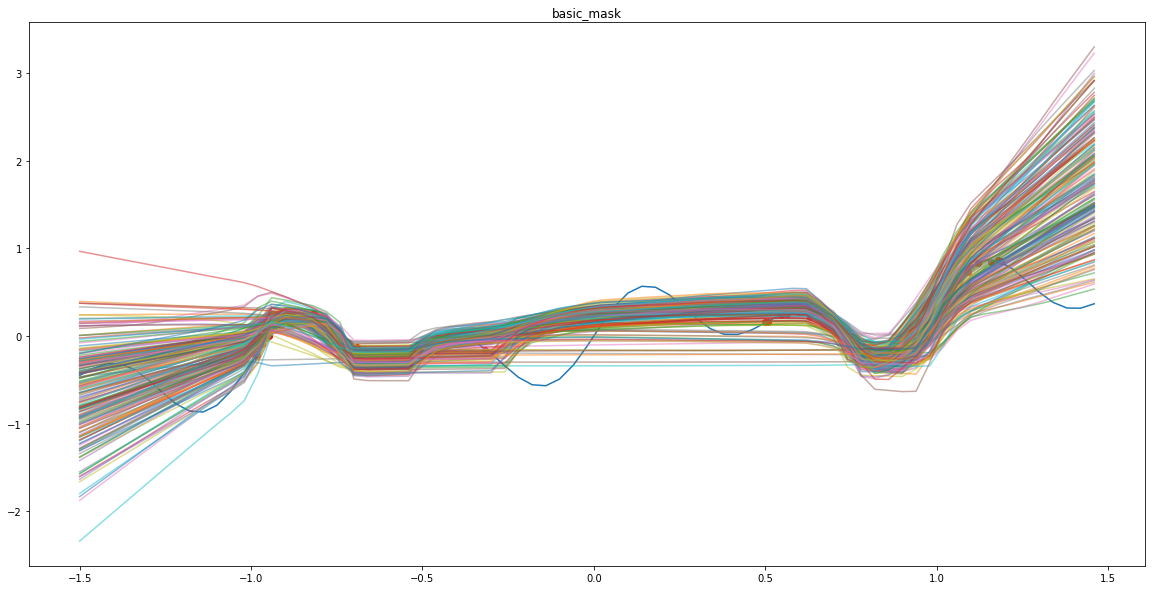

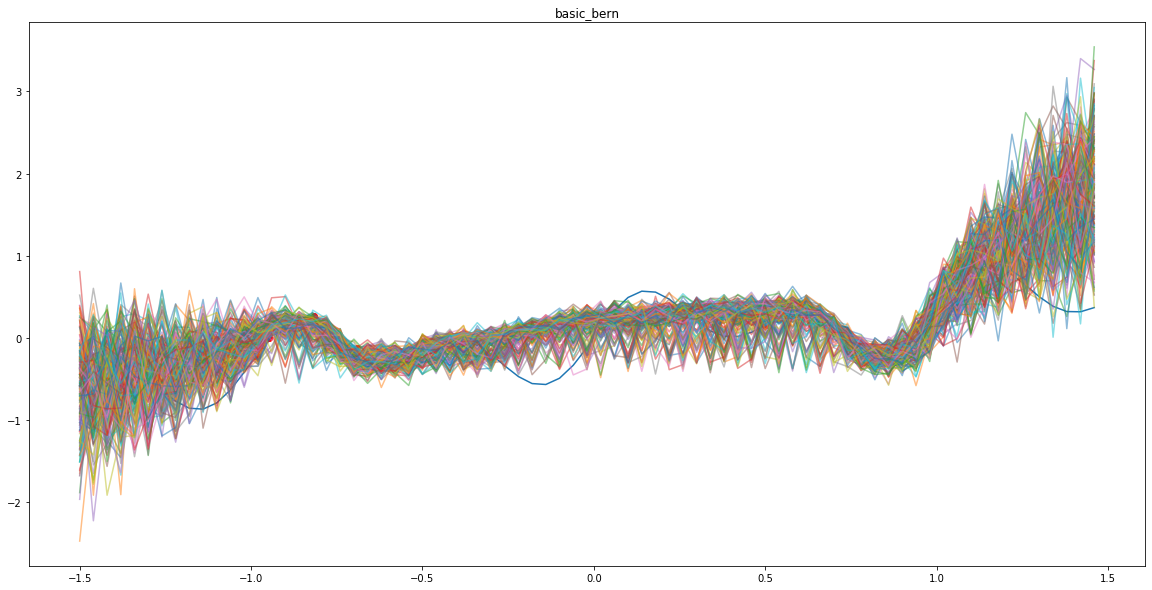

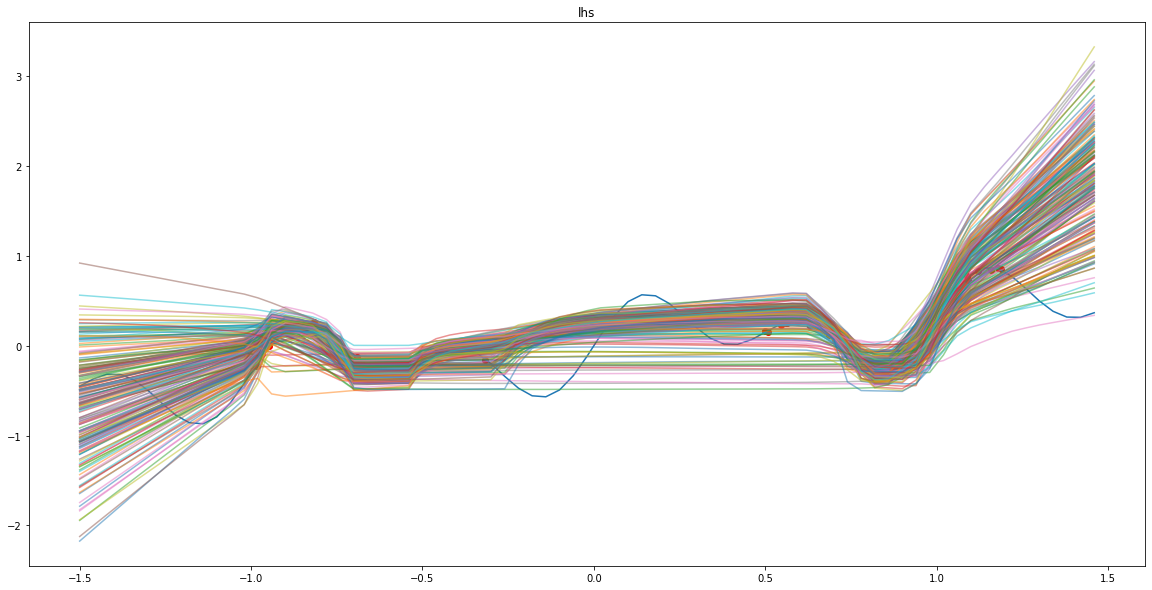

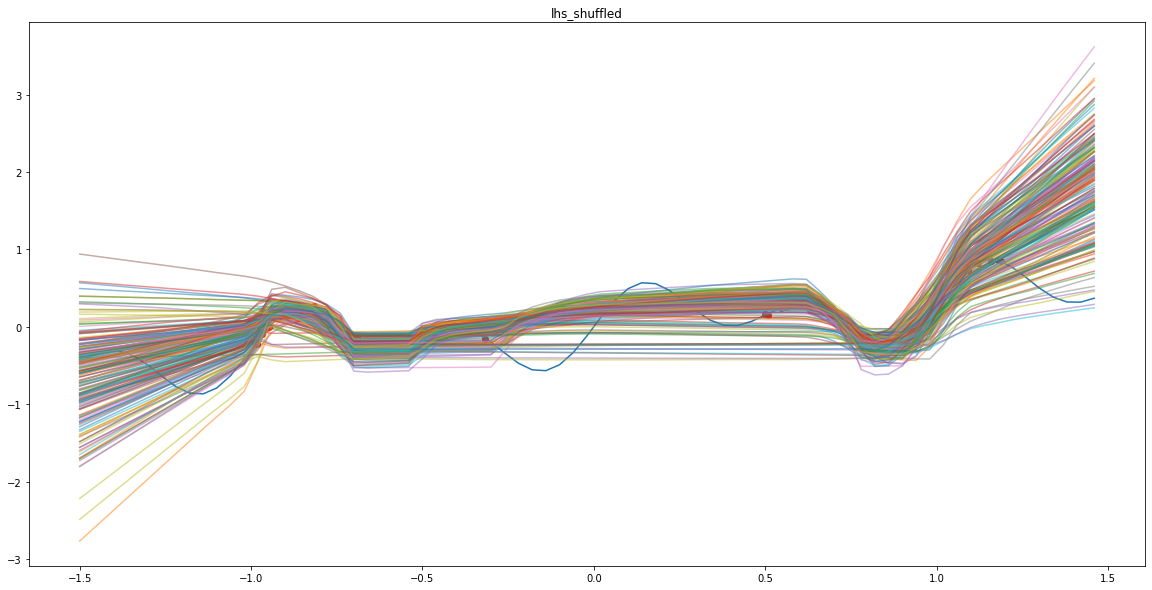

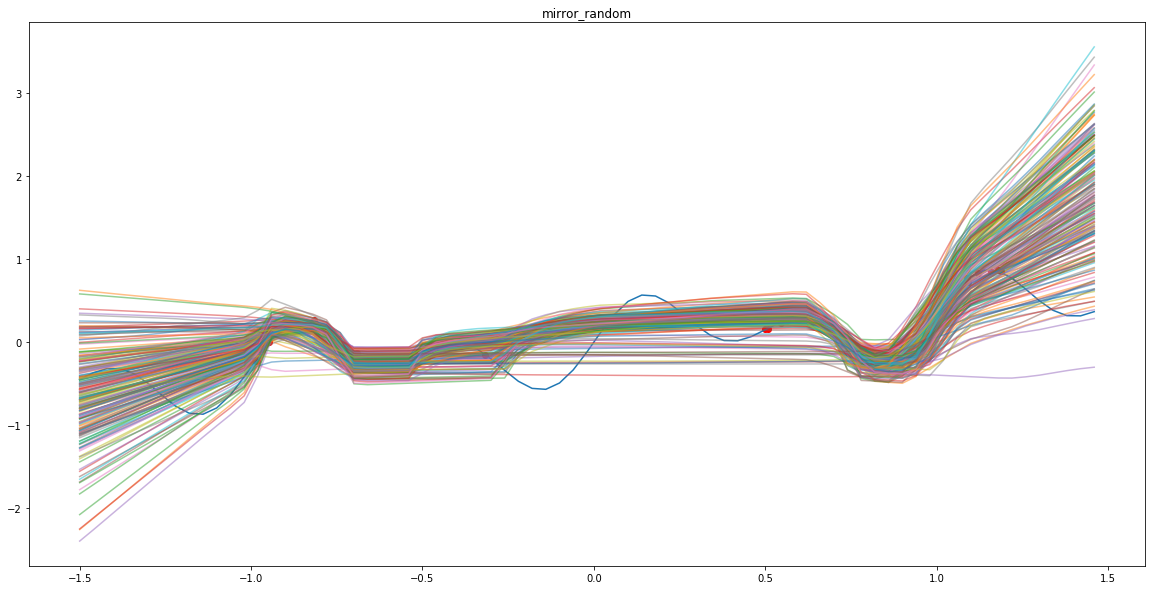

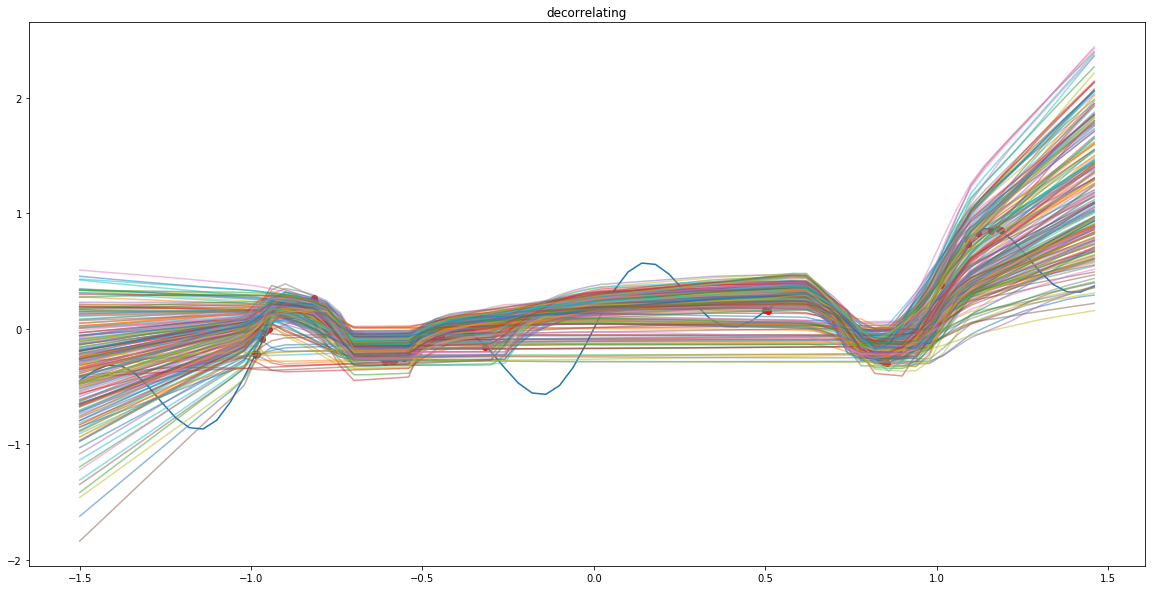

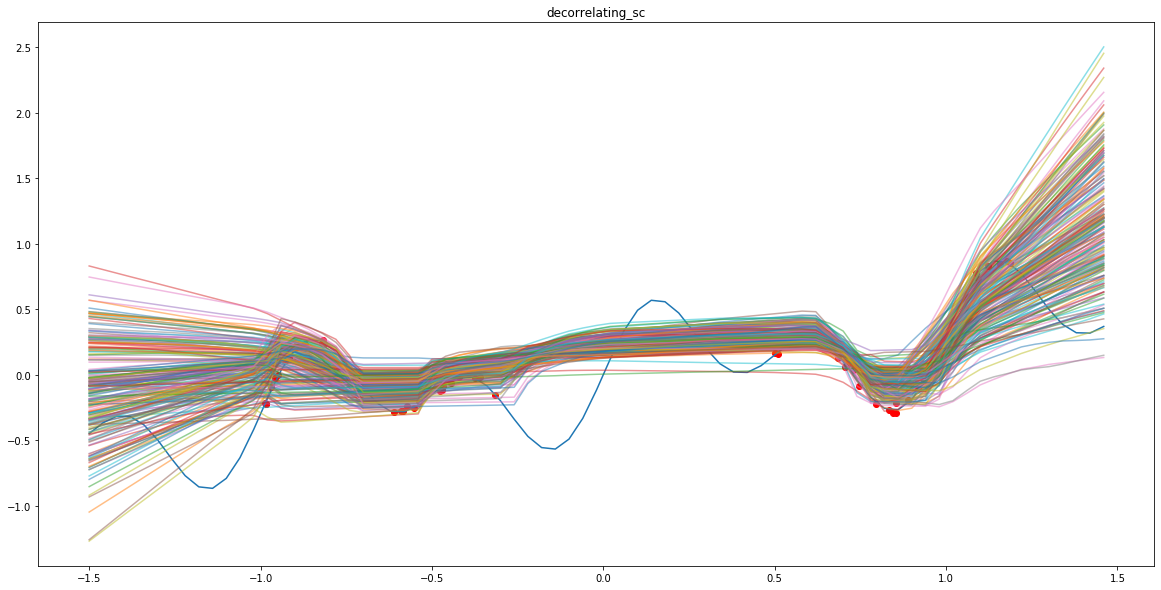

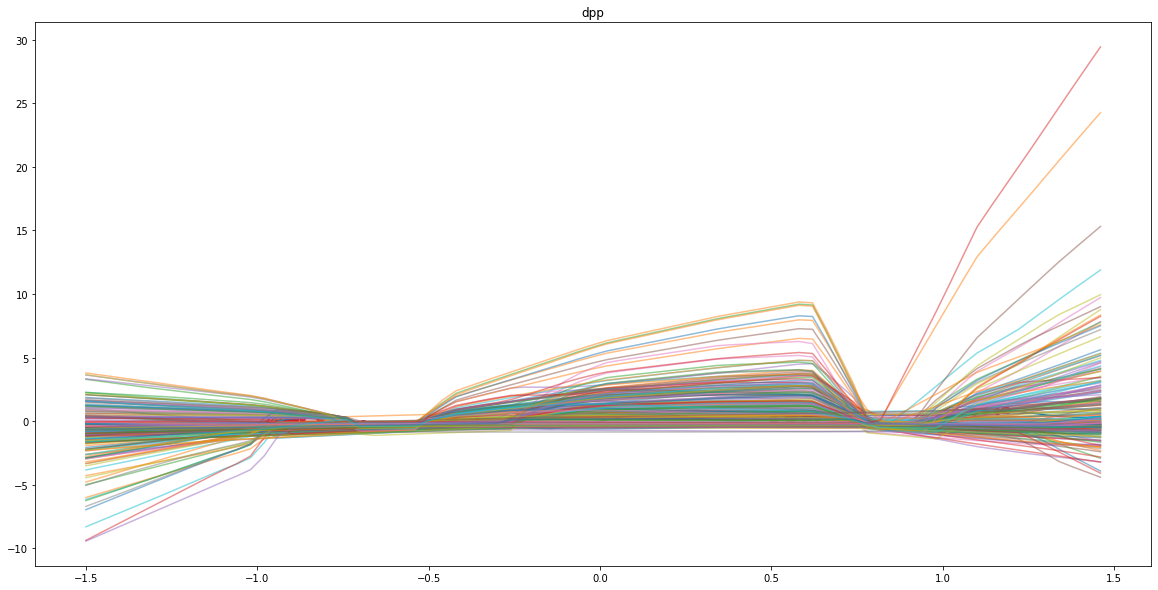

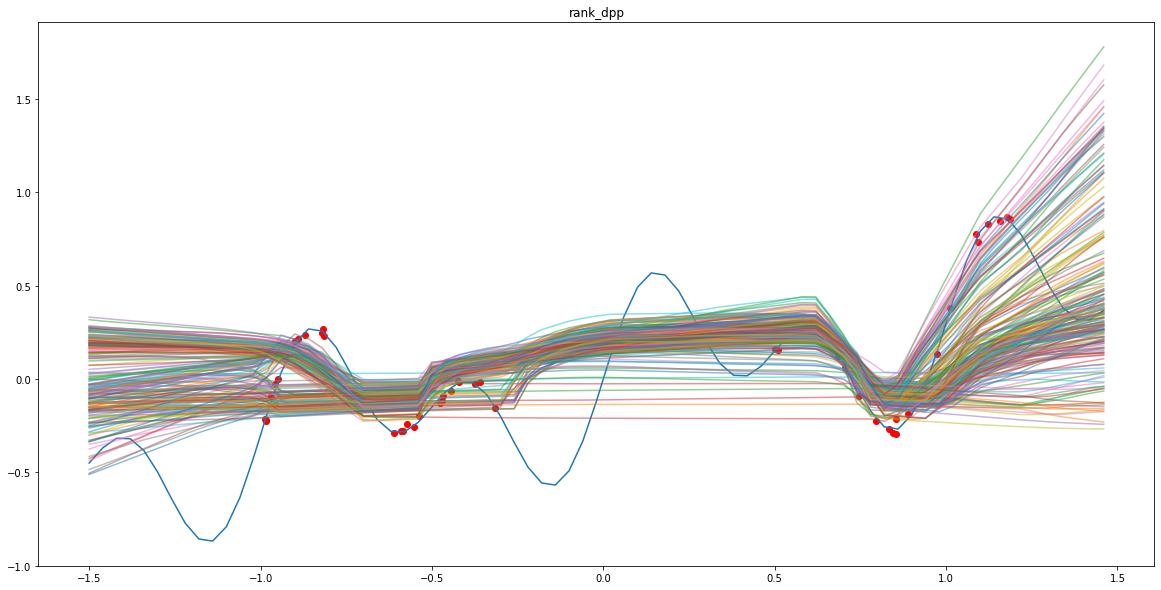

In [10]:
for name, runs in dropout_runs.items():
    plot_dropout_runs(name, runs.T, 200)
